In [33]:

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import mapclassify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches


### Connect CBS count + dat from CBS

### Interval Count Creation 
#### Think along from intersection we have to export always then the datset we need

### Create frequencies

In [37]:
def merge_interval_counts_with_cbs(interval_counts_CBS, cbs, drop_columns=['age_sum', 'migration_']) -> gpd.GeoDataFrame:
    """
    Merges interval_counts_CBS with CBS data, cleans columns, and moves geometry to the end.
    """
    merged = interval_counts_CBS.merge(cbs, how='left', on='crs28992')
    merged = merged.drop(columns=['geometry_y']).rename(columns={'geometry_x': 'geometry'})
    merged = merged.drop(columns=drop_columns)
    cols = [col for col in merged.columns if col != 'geometry'] + ['geometry']
    return merged[cols]


#### Export

In [11]:
#interval_counts_CBS_data .to_file("data/interval_counts_CBS_data_1503.shp", driver='ESRI Shapefile')

### Visualisation Frequencies

In [46]:
def plot_counts(interval_counts_CBS_data, ams_gdf, column_to_plot='count'):
    """
    Plots and returns a figure of the selected column values from interval_counts_CBS_data with the area boundary.

    Returns:
        fig (matplotlib.figure.Figure): The figure object for further use or saving.
    """
    interval_counts_CBS_data = interval_counts_CBS_data[interval_counts_CBS_data[column_to_plot] > 0]
    interval_counts_CBS_data = interval_counts_CBS_data.to_crs(ams_gdf.crs)

    plt.style.use('default')
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#898989', '#FFB668', '#85b66f'])

    fig, ax = plt.subplots(figsize=(15, 10))
    ams_gdf.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')

    classifier = mapclassify.Quantiles(interval_counts_CBS_data[column_to_plot], k=8)

    interval_counts_CBS_data.plot(
        column=column_to_plot,
        ax=ax,
        markersize=5,
        cmap=custom_cmap,
        legend=True,
        scheme='quantiles',
        classification_kwds={'k': 8},
        edgecolor='white',
        linewidth=0.35
    )

    ax.set_title(f'Frequency Map - {column_to_plot}', fontweight='bold', fontsize=12)
    ax.set_axis_off()
    return fig


In [ ]:
def plot_counts_threshold(weighted_freq_cbs, ams_gdf, column_to_plot='count', threshold=12):
    """
    Plots selected column from weighted_freq_cbs with threshold coloring:
    - Grey if value < threshold
    - Green if value >= threshold
    Includes legend. No axes.

    Returns:
        fig (matplotlib.figure.Figure): The figure object for saving or further use.
    """
    weighted_freq_cbs = weighted_freq_cbs[weighted_freq_cbs[column_to_plot] > 0]
    weighted_freq_cbs = weighted_freq_cbs.to_crs(ams_gdf.crs)

    weighted_freq_cbs['color'] = weighted_freq_cbs[column_to_plot].apply(
        lambda x: '#85b66f' if x >= threshold else '#898989'
    )

    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(15, 10))
    ams_gdf.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')

    weighted_freq_cbs.plot(
        ax=ax,
        color=weighted_freq_cbs['color'],
        markersize=5,
        edgecolor='white',
        linewidth=0.35
    )

    legend_handles = [
        mpatches.Patch(color='#898989', label=f'< {threshold} per hour'),
        mpatches.Patch(color='#85b66f', label=f'≥ {threshold} per hour')
    ]
    ax.legend(handles=legend_handles, loc='upper right', frameon=False)

    ax.set_title(f'Frequency Map - {column_to_plot} (Threshold: {threshold})', fontweight='bold', fontsize=12)
    ax.set_axis_off()
    plt.tight_layout()

    return fig

In [57]:
def plot_ratios_comparison(ratios_df):
    """
    Plots a comparison of demographic ratios using a scatter plot.

    Parameters:
        ratios_df (pd.DataFrame): DataFrame with one row of demographic ratios.

    Returns:
        fig (matplotlib.figure.Figure): The matplotlib figure object.
    """
    ratios_df_melted = ratios_df.melt(var_name='Metric', value_name='Value')

    fig, ax = plt.subplots(figsize=(14, 6))

    colors = ['#85b66f' if metric != 'A_inhab' else '#ffa3c4' for metric in ratios_df.columns]

    ax.scatter(ratios_df.columns, ratios_df.iloc[0], color=colors, s=150)

    ax.axhline(y=ratios_df['A_inhab'].iloc[0], color='#ffa3c4', linestyle='--', linewidth=2, label='A_inhab Line')

    ax.set_xlabel('Sociodemographics', fontweight='bold')
    ax.set_ylabel('Measurements', fontweight='bold')
    ax.set_title('Measurements per Person', fontweight='bold', fontsize=12)

    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    plt.tight_layout()

    return fig


In [72]:
def process_sensing_data_from_gdf(freq_cbs_data):
    """
    Processes an input GeoDataFrame, calculates weighted sums, and returns a DataFrame 
    with ratios of weighted sums to normal sums, rounded to 1 decimal point.

    Parameters:
    freq_cbs (gpd.GeoDataFrame): The input GeoDataFrame with sensing data.

    Returns:
    pd.DataFrame: A DataFrame containing the ratios of weighted sums to normal sums.
    """
    columns_to_weight = ['A_inhab', 'A_0_15', 'A_15_25', 'A_25_45', 'A_45_65', 'A_65+', 
                         'A_nederlan', 'A_west_mig', 'A_n_west_m']

    # Compute weighted and normal sums, then calculate ratios
    ratios = {
        col: (freq_cbs_data[col] * freq_cbs_data['count']).sum() / freq_cbs_data[col].sum()
        for col in columns_to_weight
    }

    ratios_df = pd.DataFrame([ratios]).round(1)
    return ratios_df


# FUNCTION

### INPUT DATA: AMS Border File 
### INPUT DATA: CBS FULL
### INPUT DATA: Interval Counts CBS 
### OUTPUT DATA: Interval Counts CBS with data
### OUTPUT DATA: PLOT Frequency Map - Counts
### OUTPUT DATA: PLOT Frequency Map - Counts with Threshold Coloring
### OUTPUT DATA: PLOT Comparison of Demographic Ratios

In [ ]:
# Import Data
ams_gdf = gpd.read_file('data/gemeente_T.shp')
cbs_gdf = gpd.read_file('data/cbs_full.shp')
# one random day 13.03. all dayfreq_cbs_1304_fullday.shp
#interval_counts_CBS = gpd.read_file("data/cbs_interval_counts_GVB_1503_fairest_top10.gpkg") 
interval_counts_CBS = gpd.read_file("data/cbs_interval_counts_GVB_1503_fairest_top25.gpkg")

column_to_plot = '4-7'
threshold = 12


In [ ]:
def pipeline_plot_frequency(interval_counts_CBS, cbs, ams_gdf, column_to_plot, threshold):
    # Merge interval counts with CBS data
    interval_counts_CBS_data = merge_interval_counts_with_cbs(
        interval_counts_CBS, cbs, drop_columns=['age_sum', 'migration_']
    )
    
    # calculate ratios
    ratios_df = process_sensing_data_from_gdf(interval_counts_CBS_data)
    
    # Plot frequency for interval '4-5'
    fig_frequency = plot_counts(interval_counts_CBS_data, ams_gdf, column_to_plot)
    
    # Plot frequency with threshold for interval '7-8'
    fig_frequency_th = plot_counts_threshold(interval_counts_CBS_data, ams_gdf, column_to_plot, threshold)
    
    # Plot frequency ratios comparison
    fig_freq_person = plot_ratios_comparison(ratios_df)

    return interval_counts_CBS_data, fig_frequency, fig_frequency_th, fig_freq_person


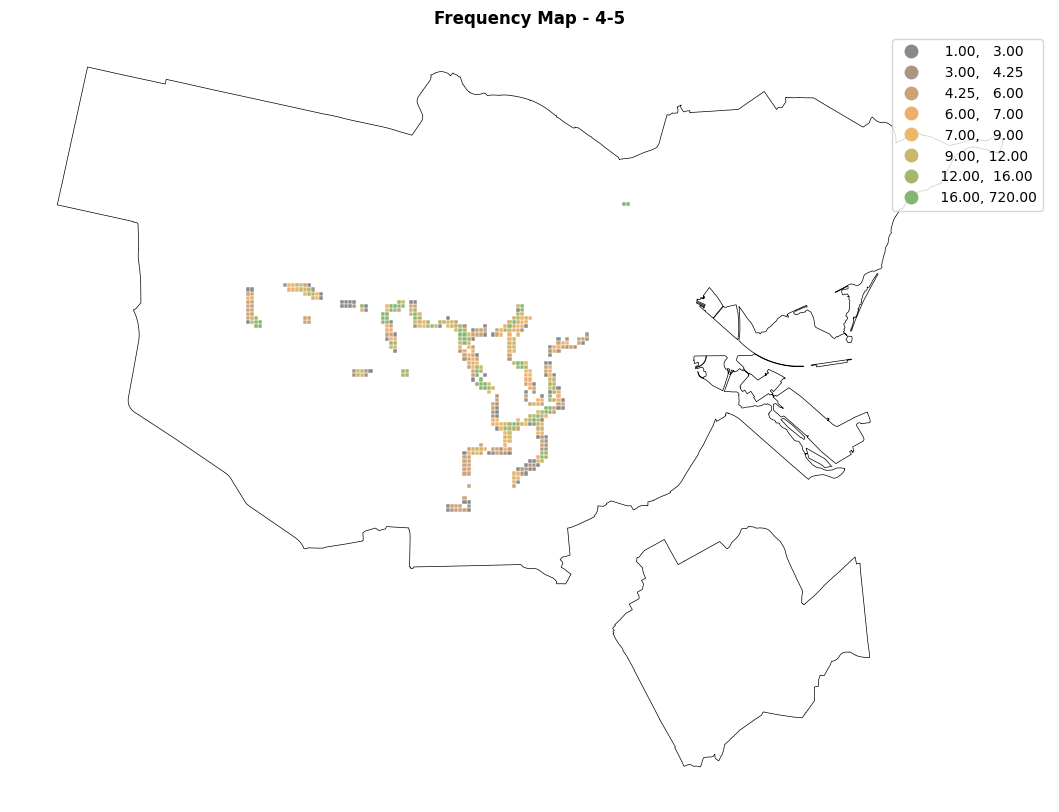

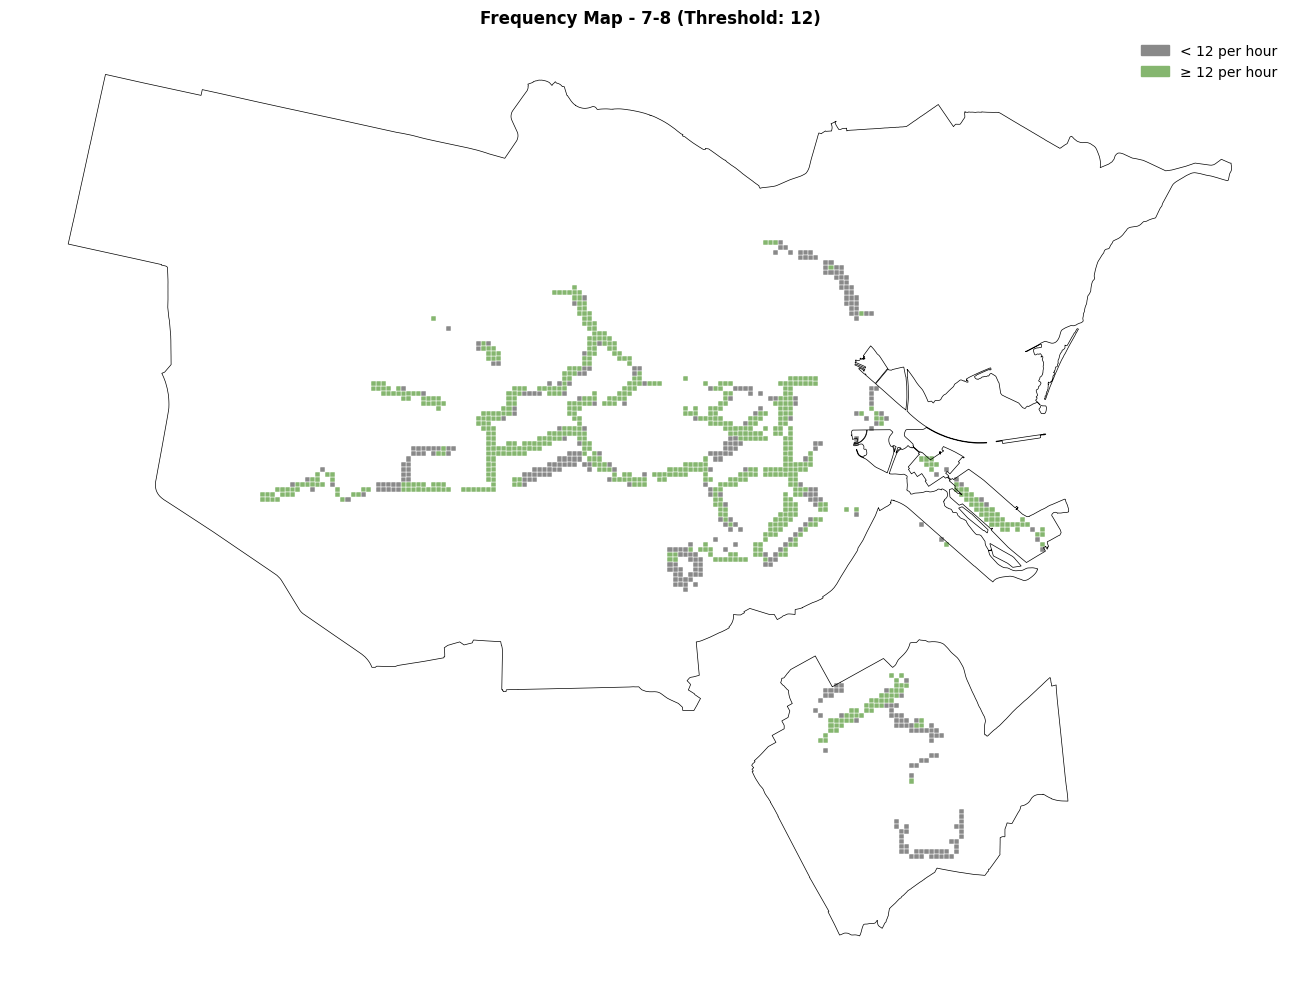

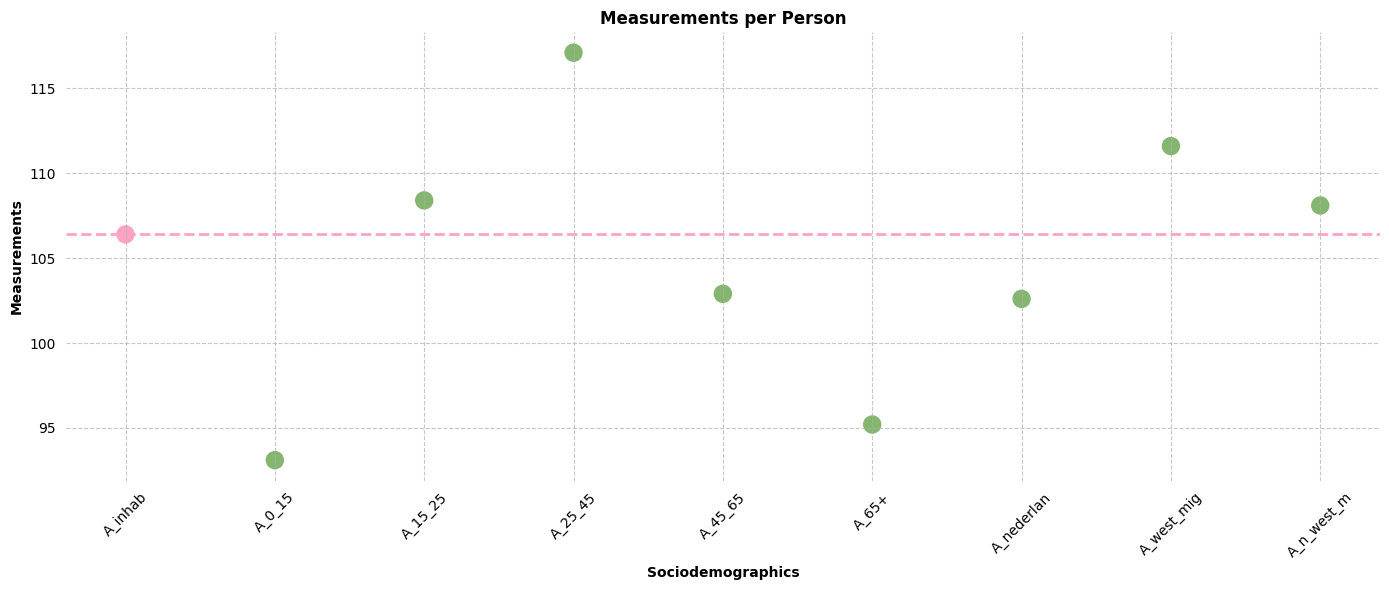

In [74]:
interval_counts_CBS_data, fig_frequency, fig_frequency_th, fig_freq_person = pipeline_plot_frequency(
    interval_counts_CBS, cbs_gdf, ams_gdf)